# Exercise 13

The result will be evaluated from a report in Jupyter, which must be found in a public GitHub repository. The project must be carried out in the groups assigned in class. Use clear and rigorous procedures. Due date: July 29, 2021, 11:59 am (NOON), through Bloque Neón + (Upload repository link).

## Analyze class homeworks


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
nltk.corpus.stopwords.words('spanish')
nltk.download('wordnet') 


from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import cross_val_score 
from sklearn.tree import DecisionTreeClassifier     
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from nltk.stem import WordNetLemmatizer


from nltk.corpus import stopwords


%matplotlib inline


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sebtc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
#Lectura del dataframe, rename y concatenado de las preguntas
data = pd.read_excel('Datasets/Consolidado_respuestas_escribir_v2.xlsx')
data.columns = ['ID', 'Genero', 'Pregrado', 'Sector_trabajo','Edad','E1','E4','E6','E8','E10','E12']
data["texto"] = data.loc[:,'E1':'E12'].astype(str).apply(' - '.join,axis=1)

# Exercise 13.1

Analyze the writing patterns of each student
<br><br>Respecto a los patrones de texto realizamos conteo palabras, signos de puntuación y saltos de linea para hacer graficos descritivos cortos controlando por genero y pregrado.

In [3]:
data['cant_palabras'] = data['texto'].str.split().apply(len)/6
data['signos_punt']=data['texto'].str.count(',|;|:')/6
data['saltos_linea']=data['texto'].str.count('\n')/6

### Comparación por genero
Observamos que en promedio los textos escritos por mujeres son mas extensos y cercanos al requisito de 300 palabras en cada pregunta; de igual manera tenemos mayor uso de signos de puntuación en los textos escritos por mujeres.
<br>Respecto a la cantidad de parrafos podemos ver que es bastante cercano entre hombres y mujeres.

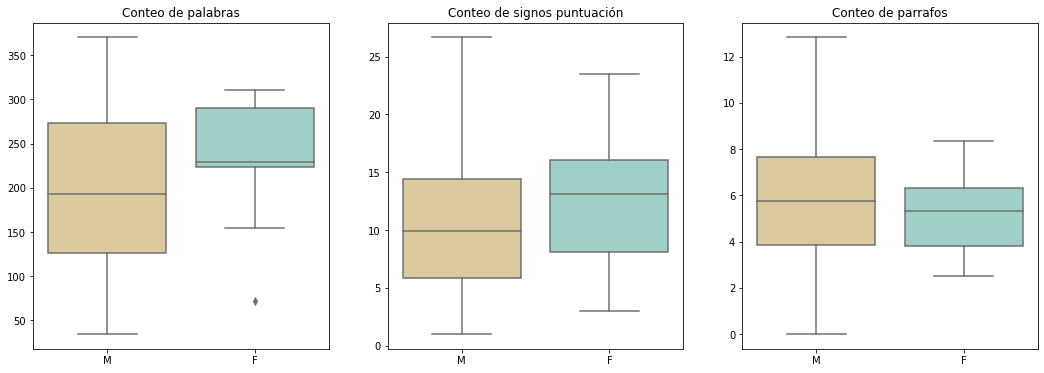

In [4]:
fig, axs = plt.subplots(ncols=3,figsize=(18,6))
sns.boxplot(data=data,  x='Genero', y='cant_palabras', ax=axs[0], palette="BrBG")
axs[0].set_title("Conteo de palabras");axs[0].set(ylabel='',xlabel='')
sns.boxplot(data=data,  x='Genero', y='signos_punt', ax=axs[1], palette="BrBG")
axs[1].set_title("Conteo de signos puntuación");axs[1].set(ylabel='',xlabel='')
sns.boxplot(data=data,  x='Genero', y='saltos_linea', ax=axs[2], palette="BrBG")
axs[2].set_title("Conteo de parrafos");axs[2].set(ylabel='',xlabel='');

### Comparación por carrera del pregrado
Como paso previo agrupamos las carreras en 4 categorias.
<br>Observamos que la distribución de la longitud de los textos varia significativamente según la carrera del estudiante.
<br>Esto ocurre tambien con la cantidad de signos de puntuación y parrafos.

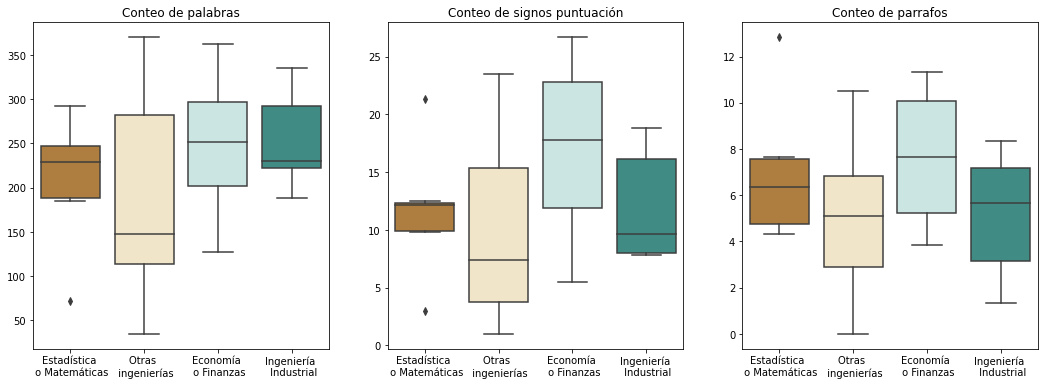

In [5]:
data['Pregrado_ct']=data['Pregrado'].str.lower()
data['Pregrado_ct']=np.where(data['Pregrado_ct'].str.contains('ingen')&data['Pregrado_ct'].str.contains('ind'),'Ingeniería \n Industrial',data['Pregrado_ct'])
data['Pregrado_ct']=np.where(data['Pregrado_ct'].str.contains('ing'),'Otras \n ingenierías',data['Pregrado_ct'])
data['Pregrado_ct']=np.where(data['Pregrado_ct'].str.contains('estad|matem'),'Estadística \n o Matemáticas',data['Pregrado_ct'])
data['Pregrado_ct']=np.where(data['Pregrado_ct'].str.contains('econ|fin'),'Economía \n o Finanzas',data['Pregrado_ct'])

fig, axs = plt.subplots(ncols=3,figsize=(18,6))
sns.boxplot(data=data,  x='Pregrado_ct', y='cant_palabras', ax=axs[0], palette="BrBG")
axs[0].set_title("Conteo de palabras");axs[0].set(ylabel='',xlabel='')
sns.boxplot(data=data,  x='Pregrado_ct', y='signos_punt', ax=axs[1], palette="BrBG")
axs[1].set_title("Conteo de signos puntuación");axs[1].set(ylabel='',xlabel='')
sns.boxplot(data=data,  x='Pregrado_ct', y='saltos_linea', ax=axs[2], palette="BrBG")
axs[2].set_title("Conteo de parrafos");axs[2].set(ylabel='',xlabel='');

# Exercise 13.2

Create a classifier to predict the gender of each student

In [6]:
print(data['Genero'].value_counts())
y_genero = data['Genero']

M    28
F    10
Name: Genero, dtype: int64


In [7]:
%%time
#Limpieza del texto
import re
def pre_process(text):
    # lowercase
    text = text.lower()
    # tags
    text = re.sub('&lt;/?.*?&gt;',' &lt;&gt; ',text)
    # special characters and digits
    text=re.sub('(\\d|\\W)+',' ',text)
    # remove punctuation
    #text = re.sub('[.;:!\'?,\"()\[\]]', '', text)
    #text = [REPLACE.sub('', line) for line in text]
    
    return text
data['texto_clean']=data['texto'].apply(lambda x:pre_process(x))

import nltk
nltk.corpus.stopwords.words('spanish')
nltk.download('wordnet') 
from nltk.corpus import stopwords


spanish_stop_words=stopwords.words('spanish')
def remove_stop_words(corpus):
    removed_stop_words = []
    for review in corpus:
        removed_stop_words.append(
            ' '.join([word for word in review.split() 
                      if word not in spanish_stop_words])
        )
    return removed_stop_words

data['texto_clean'] = remove_stop_words(data['texto_clean'])


from nltk.stem.porter import PorterStemmer
def get_stemmed_text(corpus):
    stemmer = PorterStemmer()
    return [' '.join([stemmer.stem(word) for word in review.split()]) for review in corpus]

data['texto_clean'] = get_stemmed_text(data['texto_clean'])
data[['texto','texto_clean']].head()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sebtc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Wall time: 1.15 s


,texto,texto_clean
0,Dentro de las diferentes aplicaciones que tien...,dentro diferent aplicacion seri tiempo vida re...
1,nan - una serie de tiempo se enfoca en un indi...,nan seri tiempo enfoca individio mientra dato ...
2,Mercados energeticos: Tras la liberación y des...,mercado energetico tra liberación desregulació...
3,Las series de tiempo son una colección de obse...,seri tiempo colección observacion obtenida tra...
4,"1. Actualmente, la empresa de mascotas Laika q...",actualment empresa mascota laika quier optimiz...


In [8]:
count_vect = CountVectorizer(ngram_range=(1,2),lowercase=True,stop_words=spanish_stop_words,max_features=100)
tfidf_vect = TfidfVectorizer(ngram_range=(1,2),lowercase=True,stop_words=spanish_stop_words,max_features=100)

In [9]:
text = data["texto_clean"].fillna("Sin texto")
count_vect.fit(text);text_dtm_count = count_vect.transform(text)
text_dtm_count=np.c_[text_dtm_count.todense(),data['cant_palabras'],data['signos_punt'],data['saltos_linea']]
tfidf_vect.fit(text);text_dtm_tfidf = tfidf_vect.transform(text)
text_dtm_tfidf=np.c_[text_dtm_tfidf.todense(),data['cant_palabras'],data['signos_punt'],data['saltos_linea']]

In [10]:
%%time
param_grid_ad = {'max_depth': [3,9,15], 
                 'n_estimators':[50,100,200],
                 'max_features': [0.4,0.7,0.9,1]}
grid_search_count = GridSearchCV(RandomForestClassifier(random_state=1), param_grid = param_grid_ad,cv = 4,scoring='accuracy')
grid_search_count.fit(text_dtm_count, y_genero)

best_depth       = grid_search_count.best_params_['max_depth']
best_features    = grid_search_count.best_params_['max_features']
best_n_estimators= grid_search_count.best_params_['n_estimators']

rfCLF = RandomForestClassifier(random_state=1,max_depth=best_depth,max_features=best_features,n_estimators=best_n_estimators)
pd.Series(cross_val_score(rfCLF, text_dtm_count, y_genero, cv=4)).describe()

Wall time: 29.9 s


count    4.000000
mean     0.738889
std      0.044905
min      0.700000
25%      0.700000
50%      0.738889
75%      0.777778
max      0.777778
dtype: float64

In [11]:
%%time
grid_search_tfidf = GridSearchCV(RandomForestClassifier(random_state=1), param_grid = param_grid_ad,cv = 4,scoring='accuracy')
grid_search_tfidf.fit(text_dtm_tfidf, y_genero)

best_depth=grid_search_tfidf.best_params_['max_depth']
best_features=grid_search_tfidf.best_params_['max_features']
best_n_estimators=grid_search_tfidf.best_params_['n_estimators']

rfCLF = RandomForestClassifier(random_state=1,max_depth=best_depth,max_features=best_features,n_estimators=best_n_estimators)
pd.Series(cross_val_score(rfCLF, text_dtm_tfidf, y_genero, cv=4)).describe()

Wall time: 31.3 s


count    4.000000
mean     0.791667
std      0.077712
min      0.700000
25%      0.758333
50%      0.788889
75%      0.822222
max      0.888889
dtype: float64

In [12]:
best_depth,best_features,best_n_estimators

(3, 0.4, 200)

Encontramos que el mejor modelo se obtiene usando TfidfVectorizer y se alcanza un accuracy promedio de 79.16%

# Exercise 13.3

Create a classifier to predict the industry in which each student works

In [13]:
data['Sector_trabajo']=data['Sector_trabajo'].str.lower()
data['Sector_trabajo']=np.where(data['Sector_trabajo'].str.contains('fin|banc'),'Financiero',data['Sector_trabajo'])
data['Sector_trabajo']=np.where(data['Sector_trabajo'].str.contains('eléc|comu|estructu|ingen|oper'),'Ingenieria',data['Sector_trabajo'])
data['Sector_trabajo']=np.where(data['Sector_trabajo'].str.contains('Fin|Ingen'),data['Sector_trabajo'],'Otros')
print(data['Sector_trabajo'].value_counts())
y_sector = data['Sector_trabajo']

Financiero    24
Otros          9
Ingenieria     5
Name: Sector_trabajo, dtype: int64


In [14]:
%%time
param_grid_ad = {'alpha': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]}

grid_search_count = GridSearchCV(MultinomialNB(), param_grid = param_grid_ad,cv = 4,scoring='accuracy')
grid_search_count.fit(text_dtm_count, y_sector)

best_alpha=grid_search_count.best_params_['alpha']

NBCLF = MultinomialNB(alpha=best_alpha)
pd.Series(cross_val_score(NBCLF, text_dtm_count, y_sector, cv=4)).describe()

Wall time: 112 ms


count    4.000000
mean     0.577778
std      0.094281
min      0.444444
25%      0.561111
50%      0.600000
75%      0.616667
max      0.666667
dtype: float64

In [15]:
%%time
grid_search_count = GridSearchCV(MultinomialNB(), param_grid = param_grid_ad,cv = 4,scoring='accuracy')
grid_search_count.fit(text_dtm_tfidf, y_sector)

best_alpha=grid_search_count.best_params_['alpha']

NBCLF = MultinomialNB(alpha=best_alpha)
pd.Series(cross_val_score(NBCLF, text_dtm_tfidf, y_sector, cv=4)).describe()

Wall time: 106 ms


count    4.000000
mean     0.661111
std      0.083887
min      0.600000
25%      0.600000
50%      0.633333
75%      0.694444
max      0.777778
dtype: float64

Encontramos que el mejor modelo se obtiene usando TfidfVectorizer y se alcanza un accuracy promedio de 66.11%.